# Introduction

The focus of lab is to investigate two fingerprint matching algorithms, namely, Minutiae Matching and Gabor Based Filtering and Matching, each one corresponding to a specific type of features used for the matching, and understand different types of threshold changes on the scores of matching.


<h3>Lab 5</h3>

In [16]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import ndimage as ndi

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, plase open you Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.filters import gabor_kernel
from skimage.util import invert
from skimage.exposure import equalize_adapthist

# custom functions
from utils.blockproc import blockproc

# Exercise 1

#### Some auxiliary functitons

In [17]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq=0.11):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

## Reading image

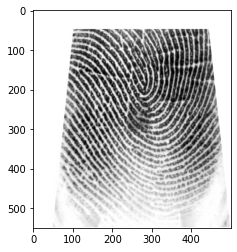

In [18]:
# the image loaded is already [0,1]
img = imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True)
plt.imshow(img, cmap='gray');

### Plotting the filters

In [19]:
#angle
angle1 = np.pi/4
angle2 = np.pi/2

# filter size: x, y
xsize = 32
ysize = 32

# standard deviation of the gaussian envelope
dx = 8
dy = 8

# frequency
fq1 = 0.11
fq2 = 0.15


plt.figure(figsize=(10,5))

# filtering and feature extraction
# build the filter
g1 = np.real(gabor_kernel(fq1, theta=angle1, sigma_x=dx, sigma_y=dy, n_stds=4))
g2 = np.real(gabor_kernel(fq1, theta=angle2, sigma_x=dx, sigma_y=dy, n_stds=4))

g3 = np.real(gabor_kernel(fq2, theta=angle1, sigma_x=dx, sigma_y=dy, n_stds=4))
g4 = np.real(gabor_kernel(fq2, theta=angle2, sigma_x=dx, sigma_y=dy, n_stds=4))

<Figure size 720x360 with 0 Axes>

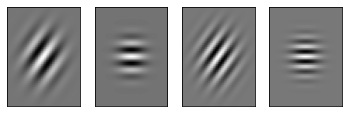

In [20]:
# show Gabor filters
plt.subplot(2, 4, 1)
plt.imshow(g1, cmap='gray', aspect='auto')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.subplot(2, 4, 2)
plt.imshow(g2, cmap='gray', aspect='auto')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.subplot(2, 4, 3)
plt.imshow(g3, cmap='gray', aspect='auto')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

plt.subplot(2, 4, 4)
plt.imshow(g4, cmap='gray', aspect='auto')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

#### 3D representation of the filter

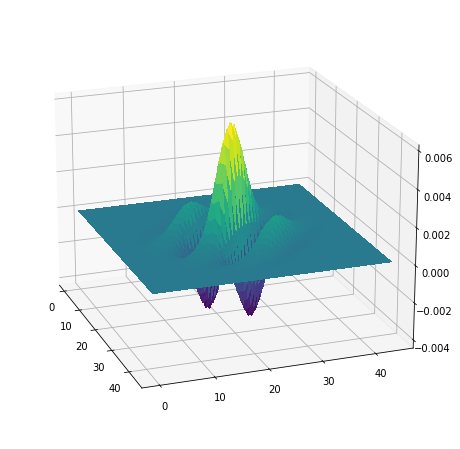

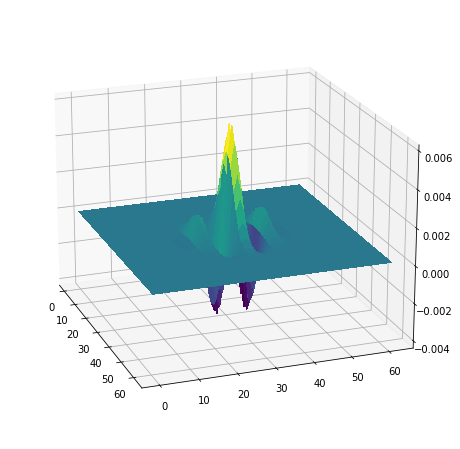

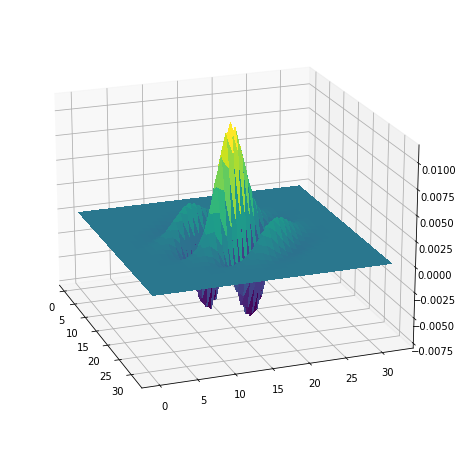

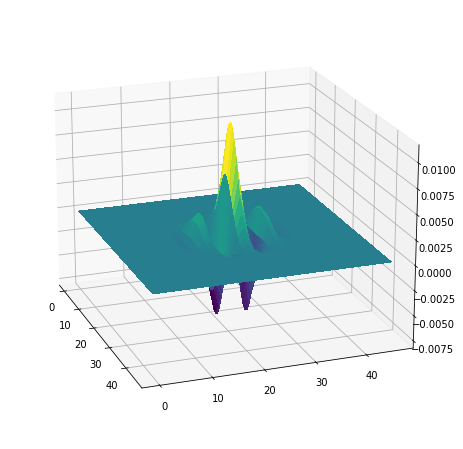

In [21]:
f1 = gabor_template(img, angle=angle1,freq=fq1)
f2 = gabor_template(img, angle=angle2,freq=fq1)
f3 = gabor_template(img, angle=angle1,freq=fq2)
f4 = gabor_template(img, angle=angle2,freq=fq2)

# Filter as a 3D function
f1_r, f1_c = f1.shape
f2_r, f2_c = f2.shape
f3_r, f3_c = f3.shape
f4_r, f4_c = f4.shape

X1 = np.arange(0, f1_c)
Y1 = np.arange(0, f1_r)
X2 = np.arange(0, f2_c)
Y2 = np.arange(0, f2_r)
X3 = np.arange(0, f3_c)
Y3 = np.arange(0, f3_r)
X4 = np.arange(0, f4_c)
Y4 = np.arange(0, f4_r)

X1, Y1 = np.meshgrid(X1, Y1)
X2, Y2 = np.meshgrid(X2, Y2)
X3, Y3 = np.meshgrid(X3, Y3)
X4, Y4 = np.meshgrid(X4, Y4)

#angle 1 frquency 1
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X1, Y1, f1, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.view_init(elev=20, azim=-20)

#angle 2 frequency 1
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X2, Y2, f2, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.view_init(elev=20, azim=-20)


#angle 1 frquency 2
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X3, Y3, f3, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.view_init(elev=20, azim=-20)

#angle 2 frequency 2
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X4, Y4, f4, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.view_init(elev=20, azim=-20)

### Gabor Filtering

In [22]:
img_f1 = gabor_filtering(img, f1)
img_f2 = gabor_filtering(img, f2)
img_f3 = gabor_filtering(img, f3)
img_f4 = gabor_filtering(img, f4)

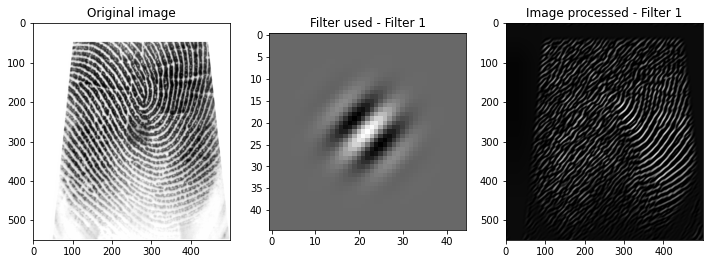

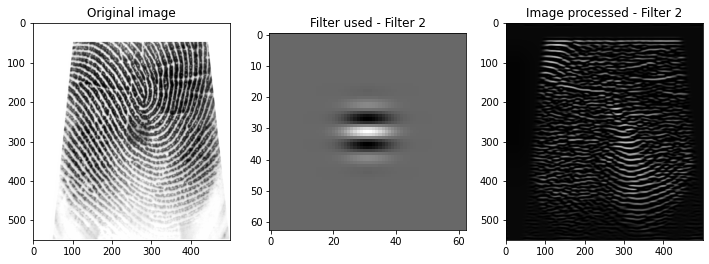

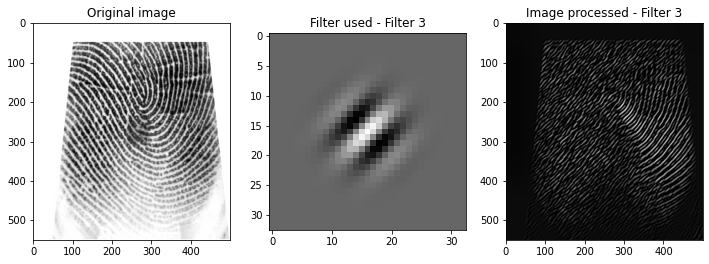

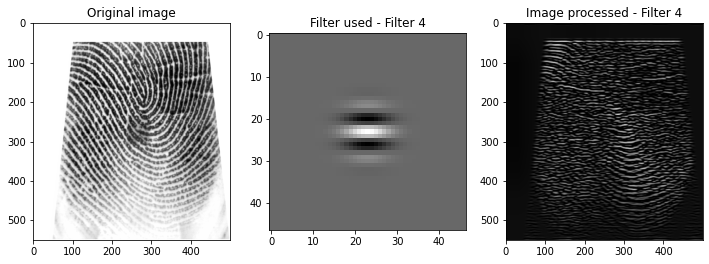

In [23]:
#filter 1
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(f1, cmap='gray'); plt.title('Filter used - Filter 1')
plt.subplot(1,3,3)
plt.imshow(img_f1, cmap='gray'); plt.title('Image processed - Filter 1');

#filter 2
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(f2, cmap='gray'); plt.title('Filter used - Filter 2')
plt.subplot(1,3,3)
plt.imshow(img_f2, cmap='gray'); plt.title('Image processed - Filter 2');

#filter 3
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(f3, cmap='gray'); plt.title('Filter used - Filter 3')
plt.subplot(1,3,3)
plt.imshow(img_f3, cmap='gray'); plt.title('Image processed - Filter 3');

#filter 4
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(f4, cmap='gray'); plt.title('Filter used - Filter 4')
plt.subplot(1,3,3)
plt.imshow(img_f4, cmap='gray'); plt.title('Image processed - Filter 4');

## Conclusion

The change in the angle of the fingerprints changes the orientation of the image. For instance, the final image 1 and 2 which have same frequency have a different orientation of about 45 degrees.

Meanwhile, the increase in frequency causes to be more crispier but also introduces a distortion in the image, the image 1 has more solid fingerprint lines meanwhile at same angle and higher frequency in image 3 has more lighter and therefore, distorted fingerprint lines.
> For example, We tried a very high frequency of 0.4 for image 3 which resulted in such a large distortion that the image was not visible anymore

# Exercise 2

#### Function for preprocessing fingerprint

In [24]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

### Loading Fingerprint database and Probe Fingerprint

In [25]:
img = []

path_dir = 'BTLab_Fingerprints/right_thumb'
path_im = ['/1.bmp', '/2.bmp', '/3.bmp', '/4.bmp', '/5.bmp', '/6.bmp', '/7.bmp', '/8.bmp', '/9.bmp']

# Loading the database images
for i in path_im:
    imag = img_as_ubyte(imread(path_dir + i, as_gray=True))

    img.append(imag)

In [26]:
# Loading the probe image
path_probe = path_dir + '/10.bmp'
probe_img = img_as_ubyte(imread(path_probe, as_gray=True))


In [27]:
proF = []

block_size = 16
seg_threshold = 0.4

# Processing the images
for im in img:
    processed_ = fingerprint_processing(im, block_size=block_size, threshold=seg_threshold)

    proF.append(processed_)


Fp = fingerprint_processing(probe_img, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 47
Total of singularities detected: 4
Total of minutiae detected: 84
Total of singularities detected: 4
Total of minutiae detected: 89
Total of singularities detected: 4
Total of minutiae detected: 56
Total of singularities detected: 4
Total of minutiae detected: 79
Total of singularities detected: 0
Total of minutiae detected: 44
Total of singularities detected: 0
Total of minutiae detected: 28
Total of singularities detected: 0
Total of minutiae detected: 56
Total of singularities detected: 4
Total of minutiae detected: 50
Total of singularities detected: 0
Total of minutiae detected: 50
Total of singularities detected: 4


## Matching based on Minutiae

In [28]:
# Matchin 1 to 1 for all the 9 finger prints
# Warning: takes about 20 mins for each iteration - total time being approx. 3 hrs

match_threshold = 6
score_minutiae = []

for fp in proF:
    imSkeletonAlign, minutiaArrayAlign = align2(Fp, fp)

    fp['imSkeletonAlign'] = imSkeletonAlign
    fp['minutiaArrayAlign'] = minutiaArrayAlign

    scr = match(Fp, fp, threshold2=match_threshold)
    score_minutiae.append(scr)

    print('Score for minutiae: %.4f\n'%(scr))


number of matched minutiae: 7
distance total computed : 31
number of minutiae in input image: 386
number of minutiae in database image: 60
Score for minutiae: 0.0314

number of matched minutiae: 5
distance total computed : 18
number of minutiae in input image: 748
number of minutiae in database image: 60
Score for minutiae: 0.0124

number of matched minutiae: 3
distance total computed : 12
number of minutiae in input image: 767
number of minutiae in database image: 60
Score for minutiae: 0.0073

number of matched minutiae: 3
distance total computed : 16
number of minutiae in input image: 503
number of minutiae in database image: 60
Score for minutiae: 0.0107

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 60
Score for minutiae: 0.0000

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 60
Score for minutiae: 0.0000

numb

##### Note : The table is below with comparison of changed threshold

#### Changing Threshold

In [43]:
# Matchin 1 to 1 for all the 9 finger prints

match_threshold = 10
score_change_thres = []

for fp in proF:

    # The following snippet of code already was executed in above loop and therefore doesn't need to be done again as
    #  it only aligns all images to the probe image and since we are using same dataset and probe, 
    # it is unnecessary to run this again
    '''
    
    imSkeletonAlign, minutiaArrayAlign = align2(Fp, fp)

    fp['imSkeletonAlign'] = imSkeletonAlign
    fp['minutiaArrayAlign'] = minutiaArrayAlign

    '''
    scr1 = match(Fp, fp, threshold2=match_threshold)
    score_change_thres.append(scr1)

    print('Score for minutiae: %.4f\n'%(scr1))

number of matched minutiae: 18
distance total computed : 124
number of minutiae in input image: 386
number of minutiae in database image: 60
Score for minutiae: 0.0807

number of matched minutiae: 10
distance total computed : 65
number of minutiae in input image: 748
number of minutiae in database image: 60
Score for minutiae: 0.0248

number of matched minutiae: 6
distance total computed : 49
number of minutiae in input image: 767
number of minutiae in database image: 60
Score for minutiae: 0.0145

number of matched minutiae: 15
distance total computed : 117
number of minutiae in input image: 503
number of minutiae in database image: 60
Score for minutiae: 0.0533

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 60
Score for minutiae: 0.0000

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 60
Score for minutiae: 0.0000


In [44]:
score_minutiae

[0.03139013452914798,
 0.012376237623762377,
 0.007255139056831923,
 0.010657193605683837,
 0.0,
 0.0,
 0.0,
 0.11469534050179211,
 0.0]

In [47]:
score_change_thres

[0.08071748878923767,
 0.024752475247524754,
 0.014510278113663845,
 0.05328596802841918,
 0.0,
 0.0,
 0.0,
 0.15412186379928317,
 0.0]

#### Table and Comparison for Minutiae matching (with change of threshold)

| Fingerprints   |      Minutiae Matching     |  Minutiae Matching with changed threshold |
|----------|-------------:|------:|
| 1 | 0.0314 | 0.0807 |
| 2 | 0.0124 | 0.0248 |
| 3 | 0.0073 | 0.0145 |
| 4 | 0.0107 | 0.0533 |
| 5 | 0.0000 | 0.0000 |
| 6 | 0.0000 | 0.0000 |
| 7 | 0.0000 | 0.0000 |
| 8 | 0.1147 | 0.1541 |
| 9 | 0.0000 | 0.0000 |

### Table for TP, FN

> The scores with positive scores are considered as True Positive as they are same fingers and matched.
> Meanwhile, the scores with 0.00 are False Negatives as they are same fingers and didn't match

The Table:

| Outcome   |    Numbers|
|----------|-------------:|
| TP | 5 |
| FN | 4 |

#### Illustration of the above comparison

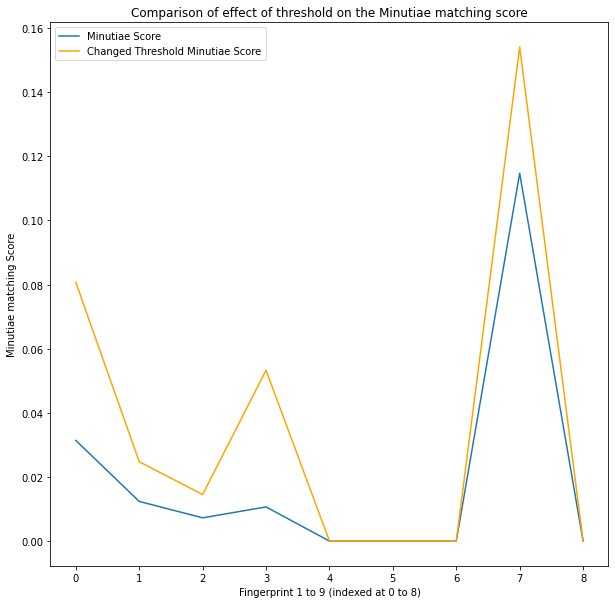

In [64]:
plt.figure(figsize=(10,10));

plt.plot(score_minutiae)
plt.plot(score_change_thres, color='Orange')

plt.xlabel("Fingerprint 1 to 9 (indexed at 0 to 8)")
plt.ylabel("Minutiae matching Score")

plt.legend(['Minutiae Score', 'Changed Threshold Minutiae Score'])
plt.title("Comparison of effect of threshold on the Minutiae matching score");

#### Conclusion

Increasing the threshold makes the score little more distinguisable and different, however, the True Positives and False Negatives stays same and therefore, doesn't show effect on matching in our case.

The best match out of all the fingers is 
##### Fingerprint number 8

# Exercise 3

In [29]:
score_gabor = []

for im in img:
    scr_g = MatchGaborFeat(probe_img, im, plot_res=False)
    print('Score using Gabor features: %.4f' % (scr_g))  

    score_gabor.append(scr_g)

Score using Gabor features: 13.0218
Score using Gabor features: 14.1728
Score using Gabor features: 14.0058
Score using Gabor features: 15.8319
Score using Gabor features: 13.7209
Score using Gabor features: 13.7784
Score using Gabor features: 15.8913
Score using Gabor features: 11.5284
Score using Gabor features: 13.3774


#### Table for Gabor Feature Matching

| Fingerprints   |      Gabor Feature Matching|
|----------|-------------:|
| 1 | 13.0218 |
| 2 | 14.1728 |
| 3 | 14.0058 |
| 4 | 15.8319 |
| 5 | 13.7209 |
| 6 | 13.7784 |
| 7 | 15.8913 |
| 8 | 11.5284 |
| 9 | 13.3774 |

### Comparison Table of Gabor Features with Minutiae Matching

| Fingerprints   |      Minutiae Matching     |  Gabor Features Matching |
|----------|-------------:|------:|
| 1 | 0.0314 | 13.0218 |
| 2 | 0.0124 | 14.1728 |
| 3 | 0.0073 | 14.0058 |
| 4 | 0.0107 | 15.8319 |
| 5 | 0.0000 | 13.7209 |
| 6 | 0.0000 | 13.7784 |
| 7 | 0.0000 | 15.8913 |
| 8 | 0.1147 | 11.5284 |
| 9 | 0.0000 | 13.3774 |

#### Conclusion

The Gabor based matching and Minutiae Matching both shows same fingerprint as their best match, i.e, `'Fingerprint 8'`

However, the Gabor based matching doesn't have any False Negatives as opposed to Minutiae matching. Moreover, certain times, gabor matching considers the fingerprint as a better match whereas minutiae matchin rejected it. For Example, fingerprint 5 and 6, where minutiae matching showed it as False Negatives, Gabor Based Matching showed them as True Positive.

### Table for TP, FN

| Outcome   |    Numbers|
|----------|-------------:|
| TP | 9 |
| FN | 0 |

# Exercise 4

In [38]:
# Creating Database

same_path_dir = 'BTLab_Fingerprints/left_thumb'

diff_path_dir = 'BTLab_Fingerprints/right_thumb'
diff_imag = ['/1.bmp', '/2.bmp', '/3.bmp', '/4.bmp', '/5.bmp', '/6.bmp', '/7.bmp', '/8.bmp', '/9.bmp', '/10.bmp']


images_data = []

probe_im = img_as_ubyte(imread(same_path_dir + '/10.bmp', as_gray=True))
images_data.append(img_as_ubyte(imread(same_path_dir + '/8.bmp', as_gray=True)))

# Loading the database images
for i in diff_imag:
    ima = img_as_ubyte(imread(diff_path_dir + i, as_gray=True))

    images_data.append(ima)


In [39]:
pro_F = []

block_size = 16
seg_threshold = 0.4

# Processing the images
for im in images_data:
    processed_ = fingerprint_processing(im, block_size=block_size, threshold=seg_threshold)

    pro_F.append(processed_)


FP = fingerprint_processing(probe_im, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 48
Total of singularities detected: 2
Total of minutiae detected: 47
Total of singularities detected: 4
Total of minutiae detected: 84
Total of singularities detected: 4
Total of minutiae detected: 89
Total of singularities detected: 4
Total of minutiae detected: 56
Total of singularities detected: 4
Total of minutiae detected: 79
Total of singularities detected: 0
Total of minutiae detected: 44
Total of singularities detected: 0
Total of minutiae detected: 28
Total of singularities detected: 0
Total of minutiae detected: 56
Total of singularities detected: 4
Total of minutiae detected: 50
Total of singularities detected: 0
Total of minutiae detected: 50
Total of singularities detected: 4
Total of minutiae detected: 84
Total of singularities detected: 4


In [ ]:
match_threshold = 6
score_minutiae1 = []

for fp in pro_F:
    imSkeletonAlign, minutiaArrayAlign = align2(FP, fp)

    fp['imSkeletonAlign'] = imSkeletonAlign
    fp['minutiaArrayAlign'] = minutiaArrayAlign

    score = match(FP, fp, threshold2=match_threshold)
    score_minutiae1.append(score)


In [48]:
score_minutiae1

[0.058287795992714025,
 0.04426559356136821,
 0.023282887077997673,
 0.029612756264236904,
 0.013029315960912053,
 0.0,
 0.0,
 0.0,
 0.021231422505307854,
 0.0,
 0.008298755186721992]

### Table for Exercise 4

|Index | Fingerprints   |      Minutiae Matching|
|---|---------|-------------:|
||Same Finger||
|1| 1  | 0.0583 |
||Different Finger||
|2| 1 | 0.0443 |
|3| 2 | 0.0233 |
|4| 3 | 0.0296 |
|5| 4 | 0.0130 |
|6| 5 | 0.0000 |
|7| 6 | 0.0000 |
|8| 7 | 0.0000 |
|9| 8 | 0.0212 |
|10| 9 | 0.0000 |
|11| 10 | 0.0083 |



#### Best Match - Same Finger

We have a true match and The True Match is on the top of the ranking.

Using, True Match's rank score as thresholding score which is `0.0583`.

### Table for TP, FN, TN, FP

| Outcome   |    Numbers|
|----------|-------------:|
| TP | 1 |
| FN | 0 |
| TN | 10 |
| FP |  0|

## Conlusion

Ideally we have chosen the threshold score as the top rank score which happened to be a true match. Therefore we had TP as 1 and TN as 10. 

However if we decide to increase threshold score above the top score, we would get TN as 10 but FN as 1. And in case if we decrease the threshold score is above the top rank, it will be considered as a mismatch and therefore, a False Negative.

Similarly, if we decide the threshold score below the top score (for example: 0.020), we would get TP as 1 meanwhile we will start to get False Positives as 4, due to their score being higher than the threshold therefore, considering them as a match.
